# Mapping OpenFEMA API Data
This notebok will retrieve IHP Valid Registrations data from the OpenFEMA API, perform some cleanup, graph a summary, and finally display on a chloropleth map by County. 

## Goals

- Accessing data via the OpenFEMA API
- Illustrating API parameters to filter, order, and select data
- Retrieve through multiple iterations (paging)
- Demonstrate free tools for ad hoc analysis

## Disclaimer
#### The focus is really on data access and data manipulation with readily available tools. This is not meant to be a deep, insightful analysis of IA/PA data. 

## Components/Tools Used
* OpenFEMA API
* Juypter notebook
* Python
  * requests - library for accessing API (alternatives: urllib, PyWGET, PyCURL)
  * pandas - data analysis libraries (alternatives: NumPy, SciPy)
  * folium - mapping 

## Retrieve Data from OpenFEMA API - Get some disaster details

In [1]:
import math
import json
import requests 
import pandas as pd
from pandas.io.json import json_normalize

# get some details for 2020 Hurricane Laura from the API
baseURL = "https://www.fema.gov/api/open/v1/FemaWebDisasterDeclarations?"
apiFilter = "$filter=disasterNumber%20eq%204559"
apiSelect = "$select=disasterNumber,declarationType,declarationDate,disasterName,incidentType,incidentBeginDate,stateName"

# call api
response = requests.get(baseURL + apiFilter + '&' + apiSelect)
jsonData = response.json()

# show raw json - formatted a little
#print(json.dumps(jsonData, indent=4, sort_keys=False))

json_normalize(jsonData,'FemaWebDisasterDeclarations')
    

,disasterNumber,declarationDate,disasterName,incidentBeginDate,declarationType,stateName,incidentType,id
0,4559,2020-08-28T00:00:00.000Z,HURRICANE LAURA,2020-08-22T00:00:00.000Z,Major Disaster,Louisiana,Hurricane,5f49b24a09b6b27ecbf1e319


## Retrieve IHP Valid Registrations data from API

In [2]:
# define the api query
baseURL = "https://www.fema.gov/api/open/v1/IndividualsAndHouseholdsProgramValidRegistrations?"
apiFilter = "$filter=damagedStateAbbreviation%20eq%20%27LA%27%20and%20disasterNumber%20eq%204559"
apiSelect = "$select=county,damagedStateAbbreviation,damagedCity,damagedZipCode,residenceType,rpfvl,ppfvl,destroyed,renterDamageLevel,ihpEligible"

# call api - JUST TO GET COUNT
response = requests.get(baseURL + apiFilter + '&' + apiSelect + '&$inlinecount=allpages&$top=1')
jsonData = response.json()
recCount = jsonData['metadata']['count']

# lets display the metadata object that is sent with every response
print(json.dumps(jsonData['metadata'], indent=4, sort_keys=False))
print(str(recCount) + ' records matching criteria')



{
    "skip": 0,
    "top": 1,
    "count": 216702,
    "filter": "damagedStateAbbreviation eq 'LA' and disasterNumber eq 4559",
    "format": "json",
    "metadata": true,
    "orderby": {},
    "select": "county damagedStateAbbreviation damagedCity damagedZipCode residenceType rpfvl ppfvl destroyed renterDamageLevel ihpEligible",
    "entityname": "IndividualsAndHouseholdsProgramValidRegistrations",
    "version": "v1",
    "url": "/api/open/v1/IndividualsAndHouseholdsProgramValidRegistrations?$filter=damagedStateAbbreviation%20eq%20%27LA%27%20and%20disasterNumber%20eq%204559&$select=county,damagedStateAbbreviation,damagedCity,damagedZipCode,residenceType,rpfvl,ppfvl,destroyed,renterDamageLevel,ihpEligible&$inlinecount=allpages&$top=1",
    "rundate": "2021-06-09T03:33:32.166Z"
}
216702 records matching criteria


### Oh no! More than 1,000 records. Page through the data to get all.

In [77]:
# set some additional api parameters
apiParams = "&$metadata=off&$format=jsona&$top=1000&$skip="

loopNum = math.ceil(recCount / 1000)    # how many loops 
jsonDataAll = []                        # initialize jsona results
i = 0

while (i < loopNum):
    response = requests.get(baseURL + apiFilter + '&' + apiSelect + apiParams + str(i * 1000))
    jsonDataAll += response.json()
    if ((i % 10) == 0):
        print(i * 1000)
    i += 1

#json_normalize(jsonDataAll)

# did we get the correct records and how much memory is it taking
from sys import getsizeof
print(str(len(jsonDataAll)) + ' records retrieved')
print(str(getsizeof(jsonDataAll)) + ' bytes used')

0
216701 records retrieved
1764104 bytes used


## Convert JSONA to a format more useful to data analysis. Save it to a file as well.

In [78]:
# convert our jsona data to a format more useful to data analysis
df = pd.DataFrame(jsonDataAll)

#save to jsona file
fpOut = open("iahpvr_all.json", "w")
json.dump(jsonDataAll, fpOut)
fpOut.close()

# lets reclaim some memory and drop the json object
del jsonDataAll

#save to file - feather format, parquet, csv 
from pandas.io.feather_format import to_feather

# check out the sizes of the 4 saved files - great compression with columnar formats
df.to_feather("iahpvr_all.feather")
df.to_parquet("iahpvr_all.parquet")
df.to_csv("iahpvr_all.csv")

100361119 bytes used


## Read from file instead (useful if doing a live demo)

In [2]:
df = pd.read_parquet('iahpvr_all.parquet', engine='pyarrow')
print(str(len(df)) + ' records read.')

216701 records read.


## Summarize our data
### Damage costs and counts by Parish and residence type

In [3]:
# use pandas dataframe groupby and aggregation features
dfSum = df.groupby(
    ['county', 'residenceType']
).agg(
    totRpfvl=('rpfvl', 'sum'),
    # FEMA-determined value of disaster-caused damage to personal property components
    totPpfvl=('ppfvl', "sum"),
    # number of records
    recCount=('id', "count"),
    destroyedCount=('destroyed', lambda x: x[x == True].count())
)

dfSum

totRpfvl   totPpfvl  recCount  \
county          residenceType                                              
Acadia (Parish) Apartment                      0.00   69680.00       195   
                Assisted Living Facility       0.00       0.00         2   
                Boat                           0.00       0.00         1   
                College Dorm                   0.00       0.00         1   
                Condo                       3002.26    1240.49         4   
...                                             ...        ...       ...   
Winn (Parish)   Military Housing               0.00       0.00         2   
                Mobile Home               456067.79  111657.24       515   
                Other                          0.00       0.00        61   
                Townhouse                      0.00       0.00         3   
                Travel Trailer             39091.70   12825.28        33   

                                          destroyedCount  
county          residenceType                             
Acadia (Parish) Apartment                              0  
                Assisted Living Facility               0  
                Boat                                   0  
                College Dorm                           0  
                Condo                                  0  
...                                                  ...  
Winn (Parish)   Military Housing                       0  
                Mobile Home                            2  
                Other                                  0  
                Townhouse                              0  
                Travel Trailer                         1  

[196 rows x 4 columns]

### Damage costs and counts by residence type

In [4]:
dfSumRT = df.groupby(
    ['residenceType']
).agg(
    # FEMA-determined value of disaster-caused damage to real property components
    totRpfvl=('rpfvl', 'sum'),
    # FEMA-determined value of disaster-caused damage to personal property components
    totPpfvl=('ppfvl', "sum"),
    # number of records
    recCount=('id', "count"),
    destroyedCount=('destroyed', lambda x: x[x == True].count())
    
)
dfSumRT['totCost (K)'] = round((dfSumRT.totRpfvl + dfSumRT.totPpfvl)/1000)
dfSumRT = dfSumRT.sort_values(by = 'totCost (K)', ascending = True)

dfSumRT

,totRpfvl,totPpfvl,recCount,destroyedCount,totCost (K)
residenceType,,,,,
Unknown,0.000000e+00,0.00,1,0,0.0
Correctional Facility,0.000000e+00,2168.53,9,0,2.0
Military Housing,0.000000e+00,15018.74,823,0,15.0
College Dorm,0.000000e+00,20093.45,109,0,20.0
Assisted Living Facility,0.000000e+00,45716.58,257,0,46.0
Condo,3.182468e+04,91840.03,446,0,124.0
Other,5.114392e+04,128265.20,5647,2,179.0
Boat,2.528220e+05,22560.51,35,0,275.0
Townhouse,4.755449e+05,999426.10,2131,0,1475.0


### Plot dollars by residence type

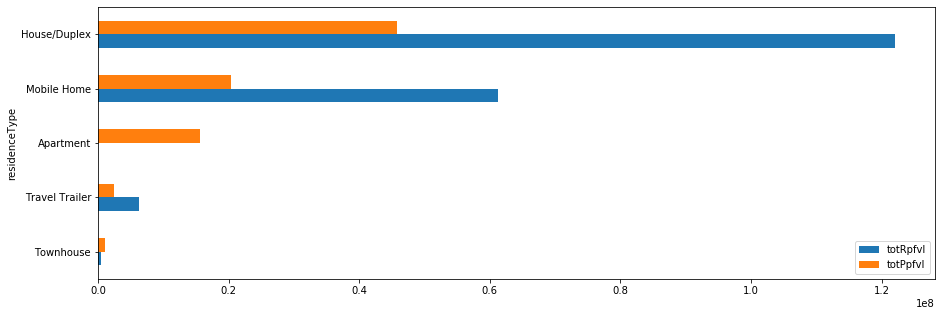

In [5]:
# lots of formatting options - not the focus of this demo

# only showing last 5 (8 to 13) becasue amounts for others are too small
dfSumRT[['totRpfvl','totPpfvl']].iloc[8:13].plot(kind='barh',stacked=False, figsize = (15,5))

## Display a map

### Need the County/Parish FIPS code - get from Census.gov

In [6]:
# for chlorpleth, I need fips code which OpenFEMA data set does not have - do some wrangling
# Note: upcoming version 3 of this dataset will have FIPS code.

# get fips from census API...
response = requests.get("https://api.census.gov/data/2010/dec/sf1?get=NAME&for=county:*&in=state:22")
jsonData = response.json()

# make a dataframe...
dfFIPS = pd.DataFrame(jsonData)
dfFIPS.drop(dfFIPS.head(1).index, inplace=True)
dfFIPS.columns = ['county','state','countyfp']

# remove state from name, and format like OpenFEMA...
dfFIPS['county'] = dfFIPS['county'].str.replace(', Louisiana','')
dfFIPS['county'] = dfFIPS['county'].str.replace('Parish','(Parish)')
#dfFIPS

### Lets view amounts by County/Parish and join with FIPS codes

In [7]:
dfSumCounty = df.groupby(
    ['county']
).agg(
    # FEMA-determined value of disaster-caused damage to real property components
    totRpfvl=('rpfvl', 'sum'),
    # FEMA-determined value of disaster-caused damage to personal property components
    totPpfvl=('ppfvl', 'sum')
)
dfSumCounty['totCost'] = round(dfSumCounty.totRpfvl + dfSumCounty.totPpfvl)

# join on county name to get fips ode
dfMap = dfSumCounty.join(dfFIPS.set_index('county'), on='county')[['countyfp','totCost']]
dfMap


,countyfp,totCost
county,,
Acadia (Parish),001,3659050.0
Allen (Parish),003,8275273.0
Beauregard (Parish),011,15916055.0
Caddo (Parish),017,5579694.0
Calcasieu (Parish),019,155779184.0
Cameron (Parish),023,24370535.0
Grant (Parish),043,4638193.0
Jackson (Parish),049,944715.0
Jefferson Davis (Parish),053,8589486.0


In [11]:
# using folium (folium is an interface to leaflet.js) to display map
import folium

# display Louisiana map by providing lat, long center point
my_map = folium.Map(location=[30.391830, -92.329102], zoom_start=7)

# added geojson layer of LA counties/parishes (https://github.com/loganpowell/census-geojson/tree/master/GeoJSON)
# as with the bar graph above, lots and lots of formatting options to make pretty - not showing here
folium.Choropleth(
    geo_data="la_county.geojson",
    data=dfMap,
    columns=['countyfp', 'totCost'],
    key_on='feature.properties.COUNTY',
    fill_color='YlOrRd',
    fill_opacity=0.2
).add_to(my_map)
my_map

# save as html
#my_map.save('la-choropleth-map-.html')